<ipython-input-12-8b45552d1458>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
<ipython-input-12-8b45552d1458>:196: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


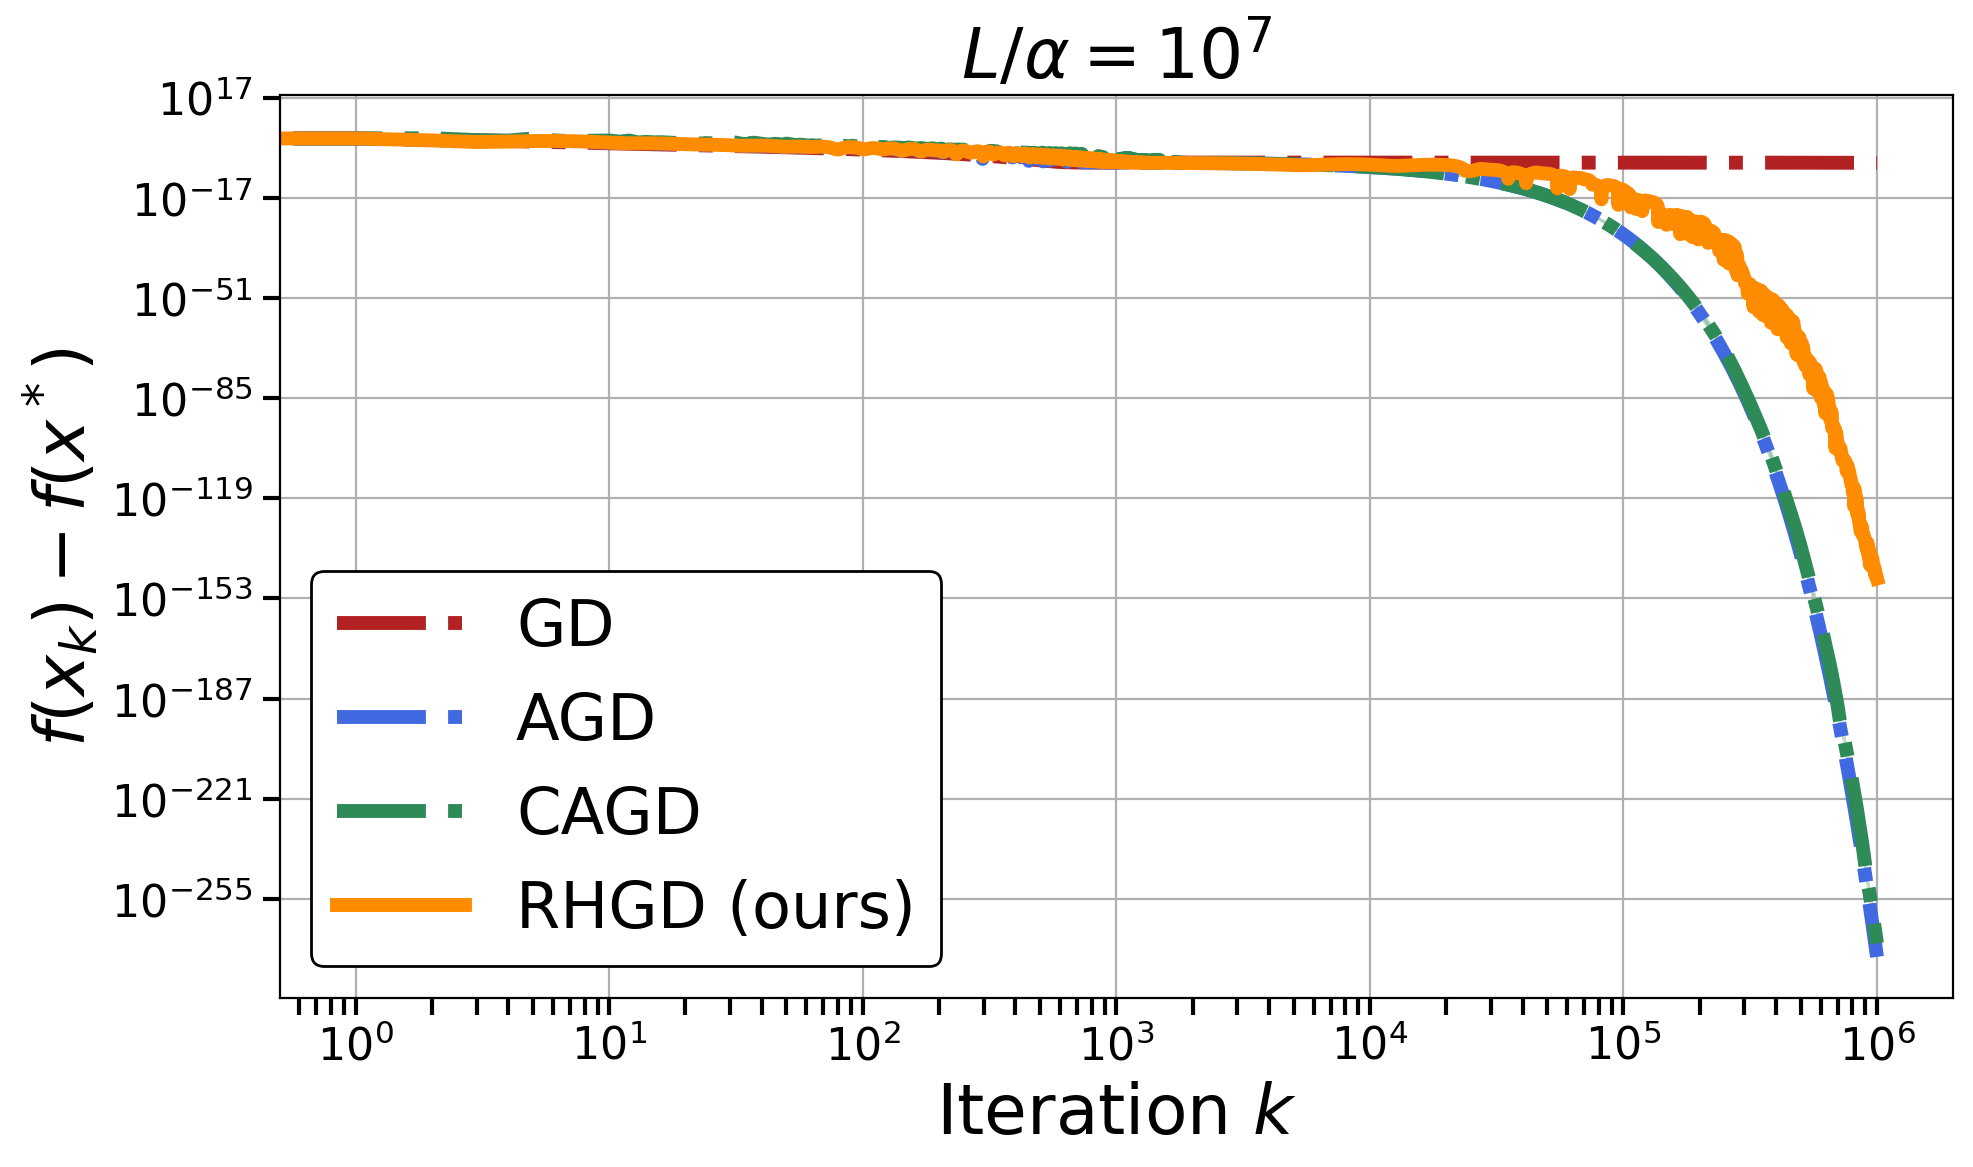

In [12]:
# Minimizing strongly convex quadratic functions with exact alpha
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

np.random.seed(42)
dim = 100
x0 = np.random.randn(dim)

# different condition number corresponds to different number of iterations
def num_iter(kappa):
  if kappa == 1e3:
    return 1e3
  elif kappa == 1e5:
    return 1e4
  elif kappa == 1e7:
    return 1e6
  else:
    return 1e4

#generate PSD matrix with specified condition number and largest eigenvalue
def generate_spd_matrix_fixed_max(dim, cond_num, lambda_max):
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))
    lambda_min = lambda_max / cond_num
    eigvals = np.linspace(lambda_max, lambda_min, dim)
    A = Q @ np.diag(eigvals) @ Q.T
    return A

'''
Specify the condition number kappa here
'''
kappa = 1e7  #we test kappa = 1e3, 1e5, and 1e7
A = generate_spd_matrix_fixed_max(dim, kappa, 500)
alpha = 500.0 / kappa
num_iters = int(num_iter(kappa))   # number of iterations

def quad_loss(x):
    return 0.5 * x @ A @ x

def quad_grad(x):
    return A @ x

# Standard Gradient Descent (GD)
def run_gd(x0, num_iters, gamma):
    x = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_new = x - gamma * quad_grad(x)
        x = x_new
    return x, losses

# Nesterov's Accelerated Gradient Descent (AGD) for strongly convex functions
def run_nag(x0, num_iters, mu, gamma):
    kappa = 1 / (mu * gamma)
    theta = (1 - np.sqrt(mu * gamma)) / (1 + np.sqrt(mu * gamma))
    x = x0.copy()
    y = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_old = x.copy()
        x = y - gamma * quad_grad(y)
        y = x + theta * (x - x_old)
    return x, losses

# Continuized Accelerated Gradient Descent (CAGD) for strongly convex functions
def stochastic_accelerated_descent(x0, gamma, mu, num_iters, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    d = len(x0)
    x = x0.copy()
    z = x0.copy()
    x_list = [x.copy()]
    fx_list = []

    # Sample T_1, ..., T_{num_iters+1} as partial sums of exponential RVs
    T = np.cumsum(rng.exponential(scale=1.0, size=num_iters + 1))
    sqrt_mu_L = np.sqrt(mu * gamma)

    for k in range(num_iters):
        fx_list.append(quad_loss(x))
        delta_t = T[k+1] - T[k]
        tau_k = 0.5 * (1 - np.exp(-2 * sqrt_mu_L * delta_t))
        tau_k_prime = np.tanh(sqrt_mu_L * delta_t)
        gamma_k = gamma
        gamma_k_prime = 1 / np.sqrt(mu / gamma)

        y = x + tau_k * (z - x)
        x_next = y - gamma_k * quad_grad(y)
        z_next = z + tau_k_prime * (y - z) - gamma_k_prime * quad_grad(y)

        x = x_next
        z = z_next

    return x, fx_list


# Randomized Hamiltonian Gradient Descent (RHGD) for strongly convex functions
def run_rhgd(x0, num_iters, h, mu, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    for k in range(num_iters):
        losses.append(quad_loss(x))
        x_half = x + h * y
        x_new = x_half - (h ** 2) * quad_grad(x_half)
        y_tilde = y - h * quad_grad(x_new)
        prob = np.sqrt(mu) * h
        if rng.random() < prob:
           y = np.zeros(dim)
        else:
           y = y_tilde
        x = x_new
    return x, losses

# generate error bar
def compute_log_curve_stats(losses_all):
    """
    Given a list of loss curves (each is a list of floats), compute:
    - mean loss
    - log10(mean)
    - log-scale std shading (upper/lower curve)
    Returns a dictionary of log10(mean), upper/lower envelope in log space, and original loss envelope.
    """
    mean_loss = np.mean(losses_all, axis=0)
    logmean = np.log10(mean_loss)
    std_loss = np.std(losses_all, axis=0)
    logstd = std_loss / (mean_loss * np.log(10))  # delta(log10(x)) ≈ std/x * 1/ln(10)

    log_lower = logmean - logstd
    log_upper = logmean + logstd
    lower = 10 ** log_lower
    upper = 10 ** log_upper

    return mean_loss, lower, upper


eta = 2e-3  # 1/L = 2e-3
h = np.sqrt(eta)

losses_gd_all, losses_nag_all, losses_cnag_all, losses_rhgd_all = [], [], [], []

for i in range(5):
    rng = np.random.default_rng(seed=i)
    _, lcnag = stochastic_accelerated_descent(x0, eta, alpha, num_iters, rng=rng)
    _, lrhgd = run_rhgd(x0, num_iters, h, alpha, rng=rng)
    losses_cnag_all.append(lcnag)
    losses_rhgd_all.append(lrhgd)

_, lgd = run_gd(x0, num_iters, eta)
_, lnag = run_nag(x0, num_iters, alpha, eta)
losses_cnag_all = np.array(losses_cnag_all)
losses_rhgd_all = np.array(losses_rhgd_all)

# error bar
mean_cnag, lower_cnag, upper_cnag = compute_log_curve_stats(losses_cnag_all)
mean_rhgd, lower_rhgd, upper_rhgd = compute_log_curve_stats(losses_rhgd_all)

for loss_curve in [lgd, lnag, mean_cnag, mean_rhgd]:
  loss_curve[0] = quad_loss(x0)

iters = np.arange(num_iters)
plt.figure(figsize=(10, 6))

plt.plot(iters, lgd, linestyle='-.', label='GD', color='firebrick', linewidth=5)
plt.plot(iters, lnag, linestyle='-.', label='AGD', color='royalblue', linewidth=5)
plt.plot(iters, mean_cnag, linestyle='-.', label='CAGD', color='seagreen', linewidth=5)
plt.fill_between(iters, lower_cnag, upper_cnag, color='seagreen', alpha=0.3)
plt.plot(iters, mean_rhgd, label='RHGD (ours)', color='darkorange', linewidth=5)
plt.fill_between(iters, lower_rhgd, upper_rhgd, color='darkorange', alpha=0.3)

plt.xlabel(r'Iteration $k$', fontsize=25)
plt.ylabel(r'$f(x_k)-f(x^*)$', fontsize=25)
plt.title(rf'$L/\alpha = 10^{{{int(np.log10(kappa))}}}$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tick_params(
axis='both',
which='both',
labelsize=16,
length=6,
width=1.5)
plt.legend(
fontsize=23,
frameon=True,
fancybox=True,
facecolor='white',
edgecolor='black',
framealpha=1.0)
plt.tight_layout()
plt.show()


<ipython-input-14-dfb199c75afd>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
<ipython-input-14-dfb199c75afd>:195: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


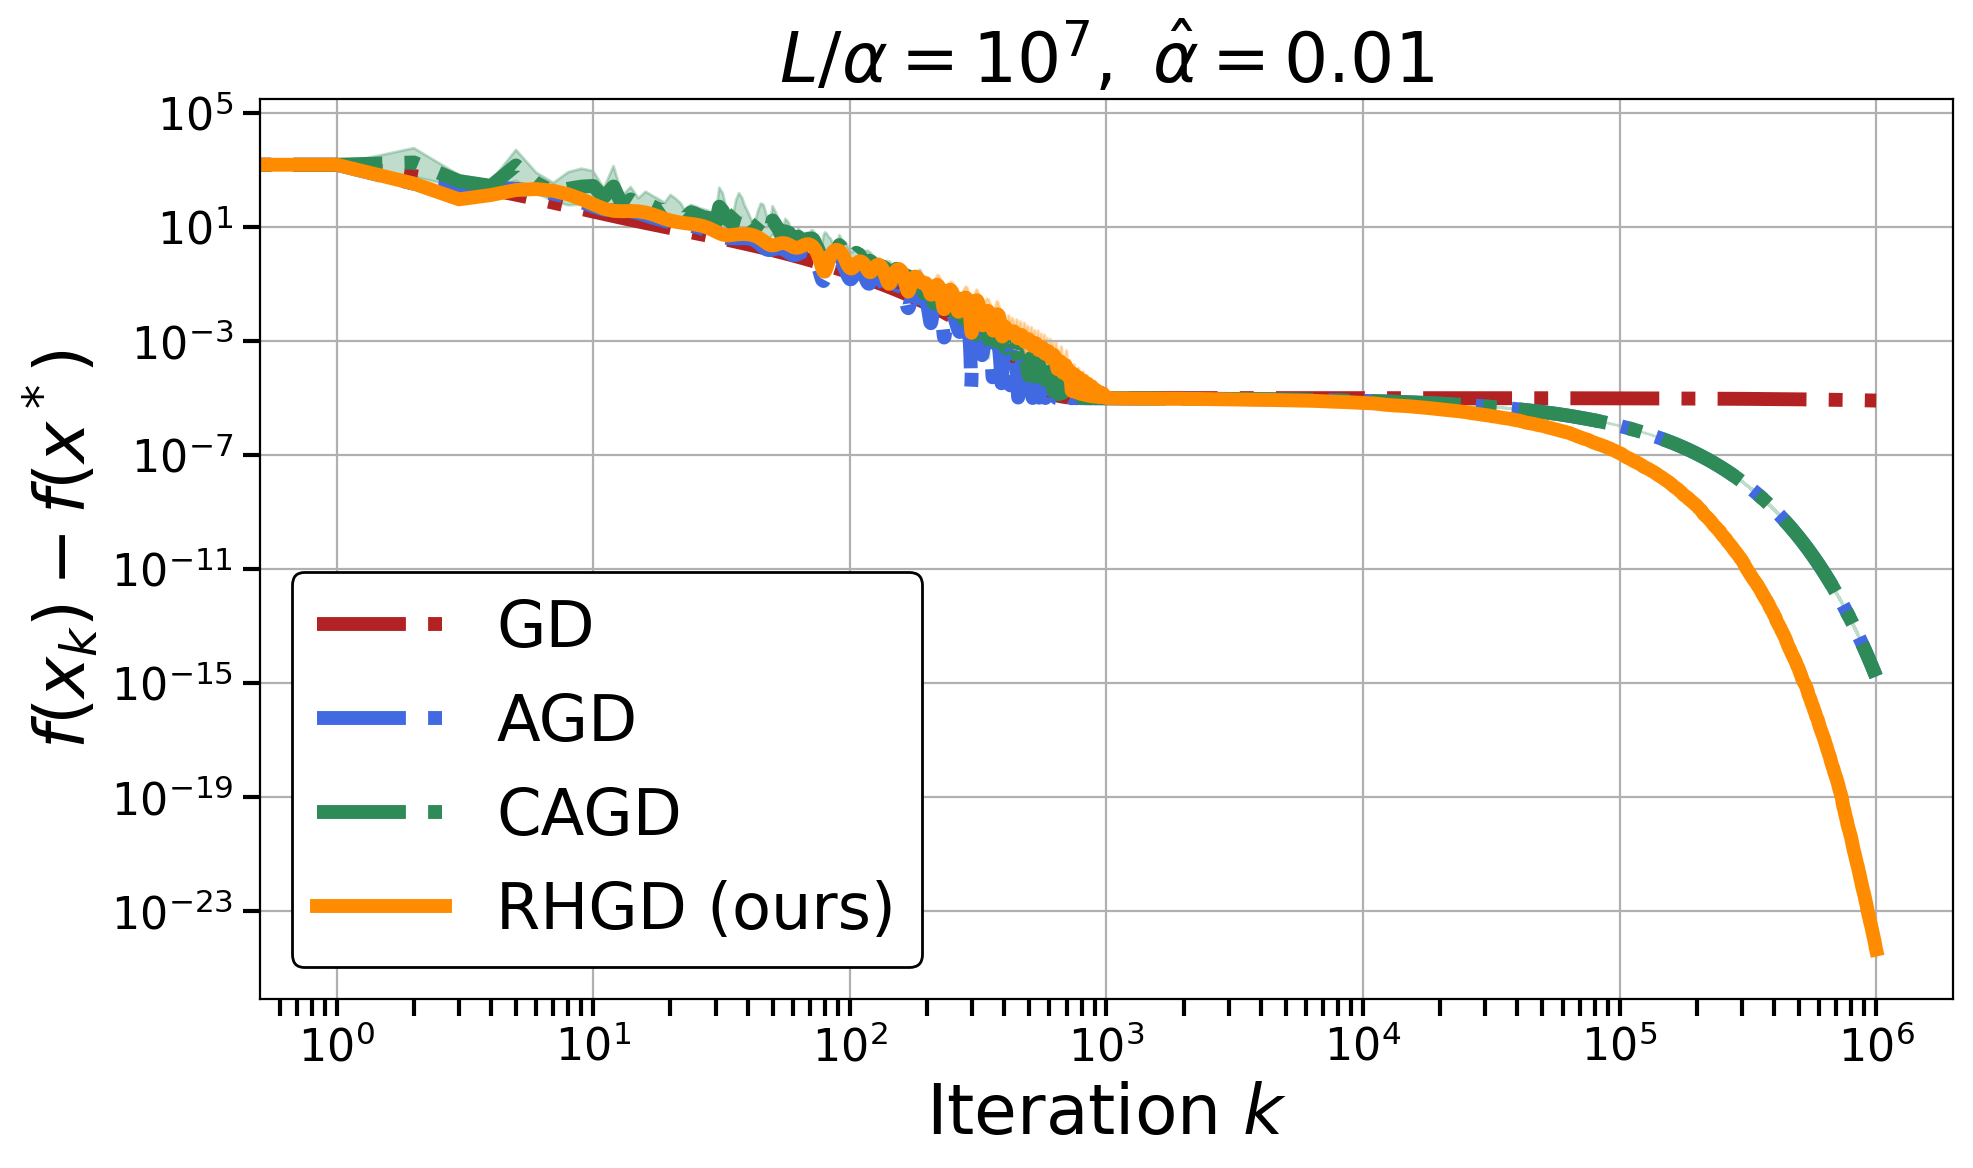

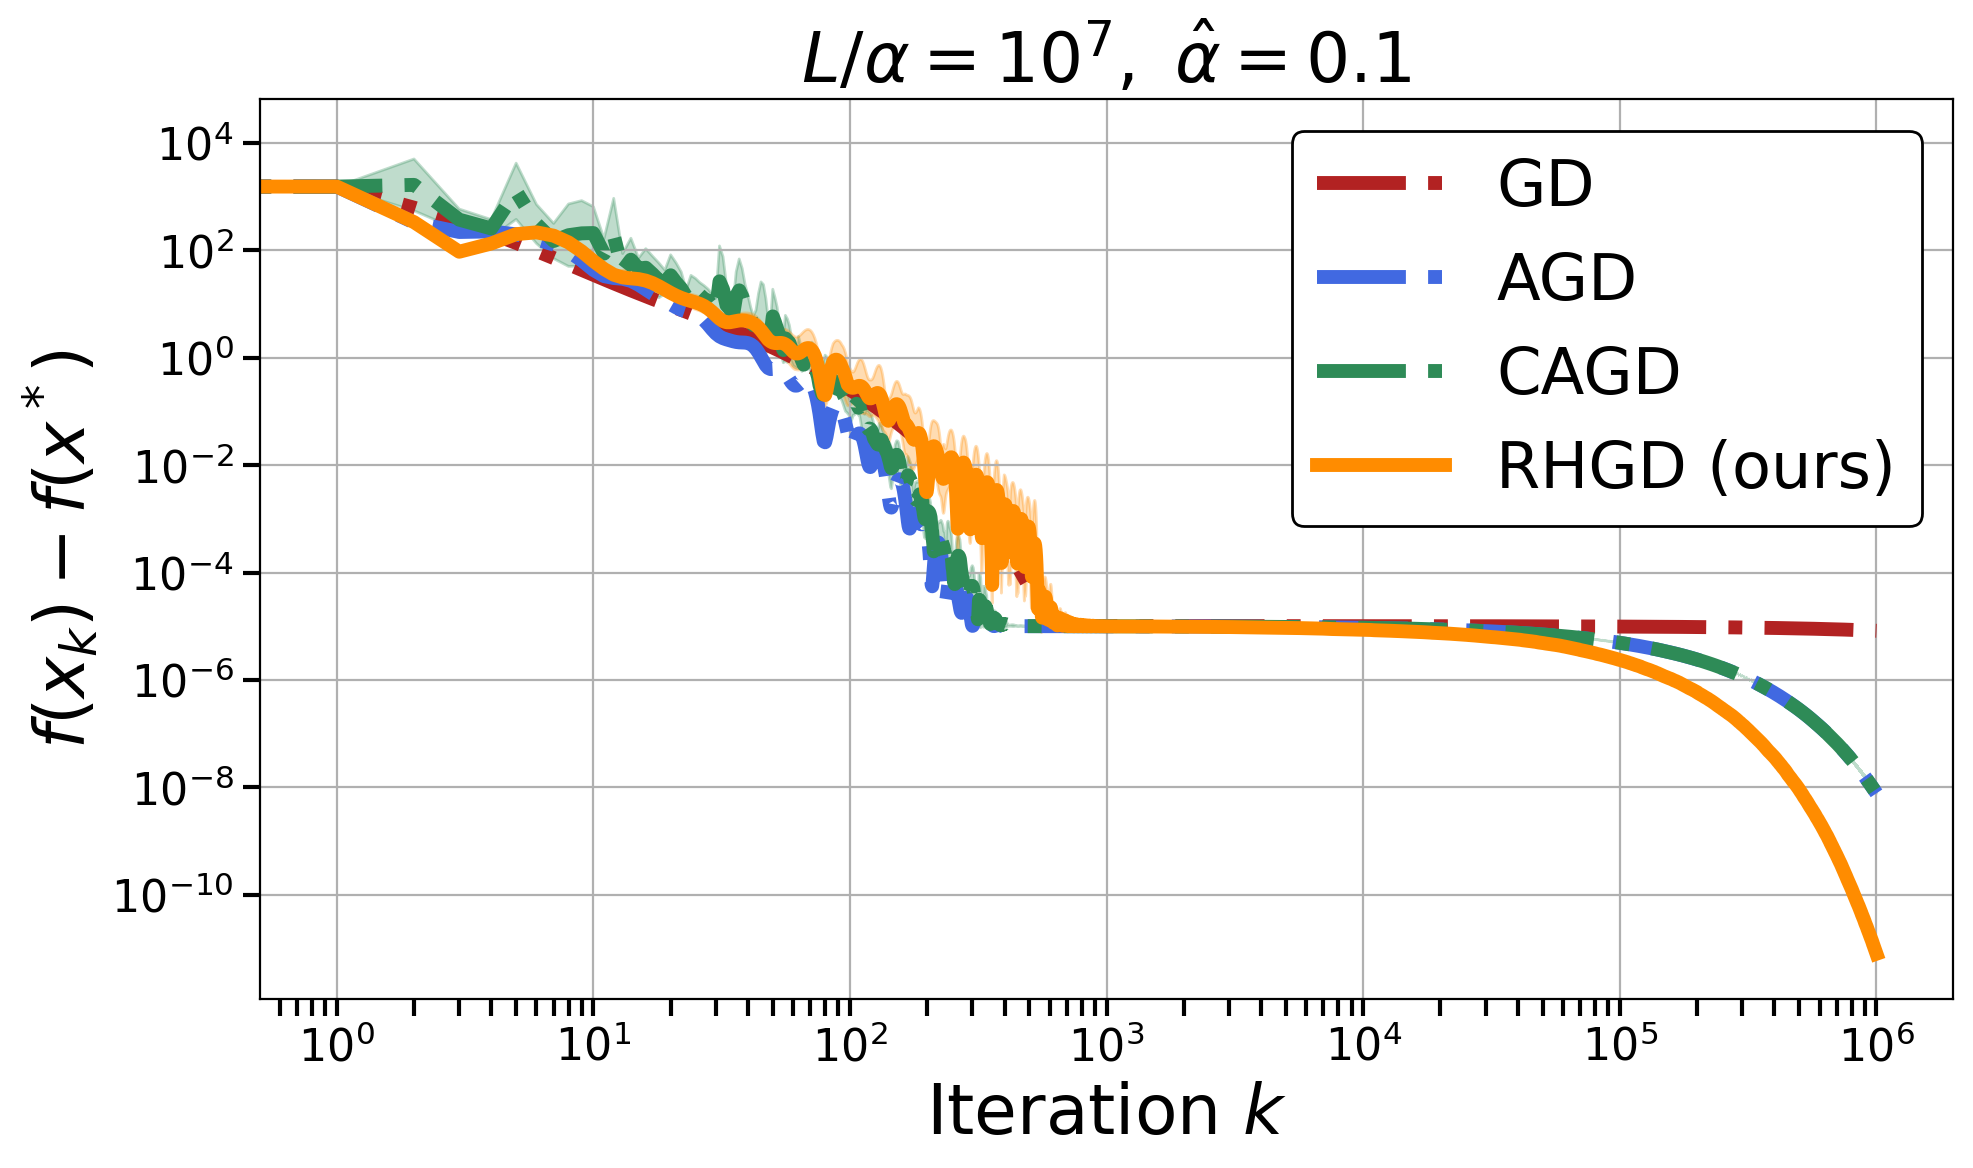

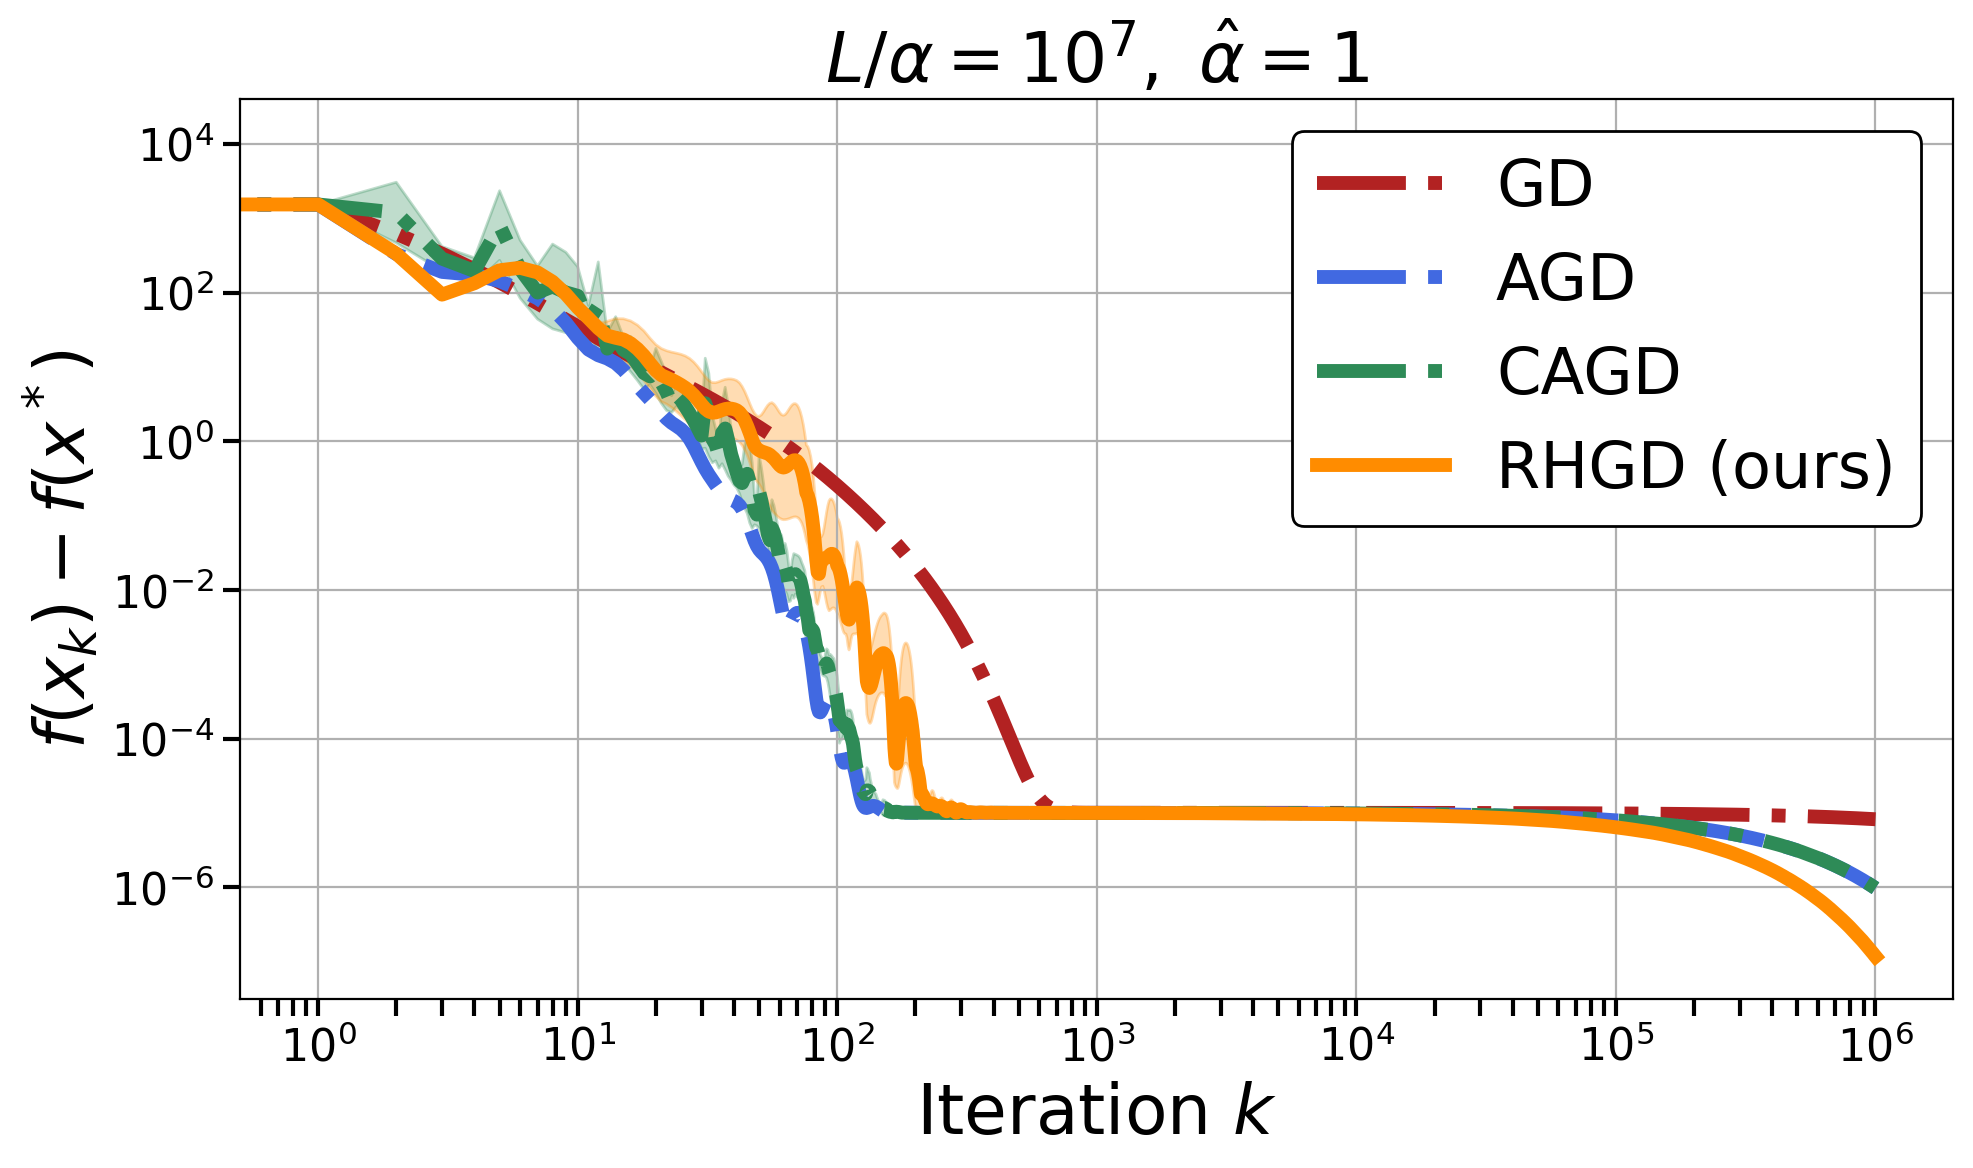

In [14]:
# Minimizing strongly convex quadratic functions with misspecified alpha
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

np.random.seed(42)
dim = 100
x0 = np.random.randn(dim)

# different condition number corresponds to different number of iterations
def num_iter(kappa):
  if kappa == 1e3:
    return 1e3
  elif kappa == 1e5:
    return 1e4
  elif kappa == 1e7:
    return 1e6
  else:
    return 1e4

#generate PSD matrix with specified condition number and largest eigenvalue
def generate_spd_matrix_fixed_max(dim, cond_num, lambda_max):
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))
    lambda_min = lambda_max / cond_num
    eigvals = np.linspace(lambda_max, lambda_min, dim)
    A = Q @ np.diag(eigvals) @ Q.T
    return A

kappa = 1e7  #we test kappa = 1e7
A = generate_spd_matrix_fixed_max(dim, kappa, 500)
num_iters = int(num_iter(kappa))   # number of iterations

def quad_loss(x):
    return 0.5 * x @ A @ x

def quad_grad(x):
    return A @ x

# Standard Gradient Descent (GD)
def run_gd(x0, num_iters, gamma):
    x = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_new = x - gamma * quad_grad(x)
        x = x_new
    return x, losses

# Nesterov's Accelerated Gradient Descent (AGD) for strongly convex functions
def run_nag(x0, num_iters, mu, gamma):
    kappa = 1 / (mu * gamma)
    theta = (1 - np.sqrt(mu * gamma)) / (1 + np.sqrt(mu * gamma))
    x = x0.copy()
    y = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_old = x.copy()
        x = y - gamma * quad_grad(y)
        y = x + theta * (x - x_old)
    return x, losses

# Continuized Accelerated Gradient Descent (CAGD) for strongly convex functions
def stochastic_accelerated_descent(x0, gamma, mu, num_iters, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    d = len(x0)
    x = x0.copy()
    z = x0.copy()
    x_list = [x.copy()]
    fx_list = []

    # Sample T_1, ..., T_{num_iters+1} as partial sums of exponential RVs
    T = np.cumsum(rng.exponential(scale=1.0, size=num_iters + 1))
    sqrt_mu_L = np.sqrt(mu * gamma)

    for k in range(num_iters):
        fx_list.append(quad_loss(x))
        delta_t = T[k+1] - T[k]
        tau_k = 0.5 * (1 - np.exp(-2 * sqrt_mu_L * delta_t))
        tau_k_prime = np.tanh(sqrt_mu_L * delta_t)
        gamma_k = gamma
        gamma_k_prime = 1 / np.sqrt(mu / gamma)

        y = x + tau_k * (z - x)
        x_next = y - gamma_k * quad_grad(y)
        z_next = z + tau_k_prime * (y - z) - gamma_k_prime * quad_grad(y)

        x = x_next
        z = z_next

    return x, fx_list


# Randomized Hamiltonian Gradient Descent (RHGD) for strongly convex functions
def run_rhgd(x0, num_iters, h, mu, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    for k in range(num_iters):
        losses.append(quad_loss(x))
        x_half = x + h * y
        x_new = x_half - (h ** 2) * quad_grad(x_half)
        y_tilde = y - h * quad_grad(x_new)
        prob = np.sqrt(mu) * h
        if rng.random() < prob:
           y = np.zeros(dim)
        else:
           y = y_tilde
        x = x_new
    return x, losses

# generate error bar
def compute_log_curve_stats(losses_all):
    """
    Given a list of loss curves (each is a list of floats), compute:
    - mean loss
    - log10(mean)
    - log-scale std shading (upper/lower curve)
    Returns a dictionary of log10(mean), upper/lower envelope in log space, and original loss envelope.
    """
    mean_loss = np.mean(losses_all, axis=0)
    logmean = np.log10(mean_loss)
    std_loss = np.std(losses_all, axis=0)
    logstd = std_loss / (mean_loss * np.log(10))  # delta(log10(x)) ≈ std/x * 1/ln(10)

    log_lower = logmean - logstd
    log_upper = logmean + logstd
    lower = 10 ** log_lower
    upper = 10 ** log_upper

    return mean_loss, lower, upper


alphas = [0.01, 0.1, 1] # we test three misspecified alpha
eta = 2e-3  # 1/L = 2e-3
h = np.sqrt(eta)

for alpha in alphas:

    losses_gd_all, losses_nag_all, losses_cnag_all, losses_rhgd_all = [], [], [], []
    # we only run randomized algorithms CAGD and RHGD for 5 times
    for i in range(5):
        rng = np.random.default_rng(seed=i)
        _, lcnag = stochastic_accelerated_descent(x0, eta, alpha, num_iters, rng=rng)
        _, lrhgd = run_rhgd(x0, num_iters, h, alpha, rng=rng)
        losses_cnag_all.append(lcnag)
        losses_rhgd_all.append(lrhgd)
    # we run deterministic algorithms GD and AGD once
    _, lgd = run_gd(x0, num_iters, eta)
    _, lnag = run_nag(x0, num_iters, alpha, eta)
    losses_cnag_all = np.array(losses_cnag_all)
    losses_rhgd_all = np.array(losses_rhgd_all)

    # error bar
    mean_cnag, lower_cnag, upper_cnag = compute_log_curve_stats(losses_cnag_all)
    mean_rhgd, lower_rhgd, upper_rhgd = compute_log_curve_stats(losses_rhgd_all)

    for loss_curve in [lgd, lnag, mean_cnag, mean_rhgd]:
      loss_curve[0] = quad_loss(x0)

    iters = np.arange(num_iters)
    plt.figure(figsize=(10, 6))

    plt.plot(iters, lgd, linestyle='-.', label='GD', color='firebrick', linewidth=5)
    plt.plot(iters, lnag, linestyle='-.', label='AGD', color='royalblue', linewidth=5)
    plt.plot(iters, mean_cnag, linestyle='-.', label='CAGD', color='seagreen', linewidth=5)
    plt.fill_between(iters, lower_cnag, upper_cnag, color='seagreen', alpha=0.3)
    plt.plot(iters, mean_rhgd, label='RHGD (ours)', color='darkorange', linewidth=5)
    plt.fill_between(iters, lower_rhgd, upper_rhgd, color='darkorange', alpha=0.3)

    plt.xlabel(r'Iteration $k$', fontsize=25)
    plt.ylabel(r'$f(x_k)-f(x^*)$', fontsize=25)
    plt.title(rf'$L/\alpha = 10^{{{int(np.log10(kappa))}}},\ \hat{{\alpha}}={alpha}$', fontsize=25)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.tick_params(
    axis='both',
    which='both',
    labelsize=16,
    length=6,
    width=1.5)
    plt.legend(
    fontsize=23,
    frameon=True,
    fancybox=True,
    facecolor='white',
    edgecolor='black',
    framealpha=1.0)
    plt.tight_layout()
    plt.show()

<ipython-input-13-9fd20cfa49bf>:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


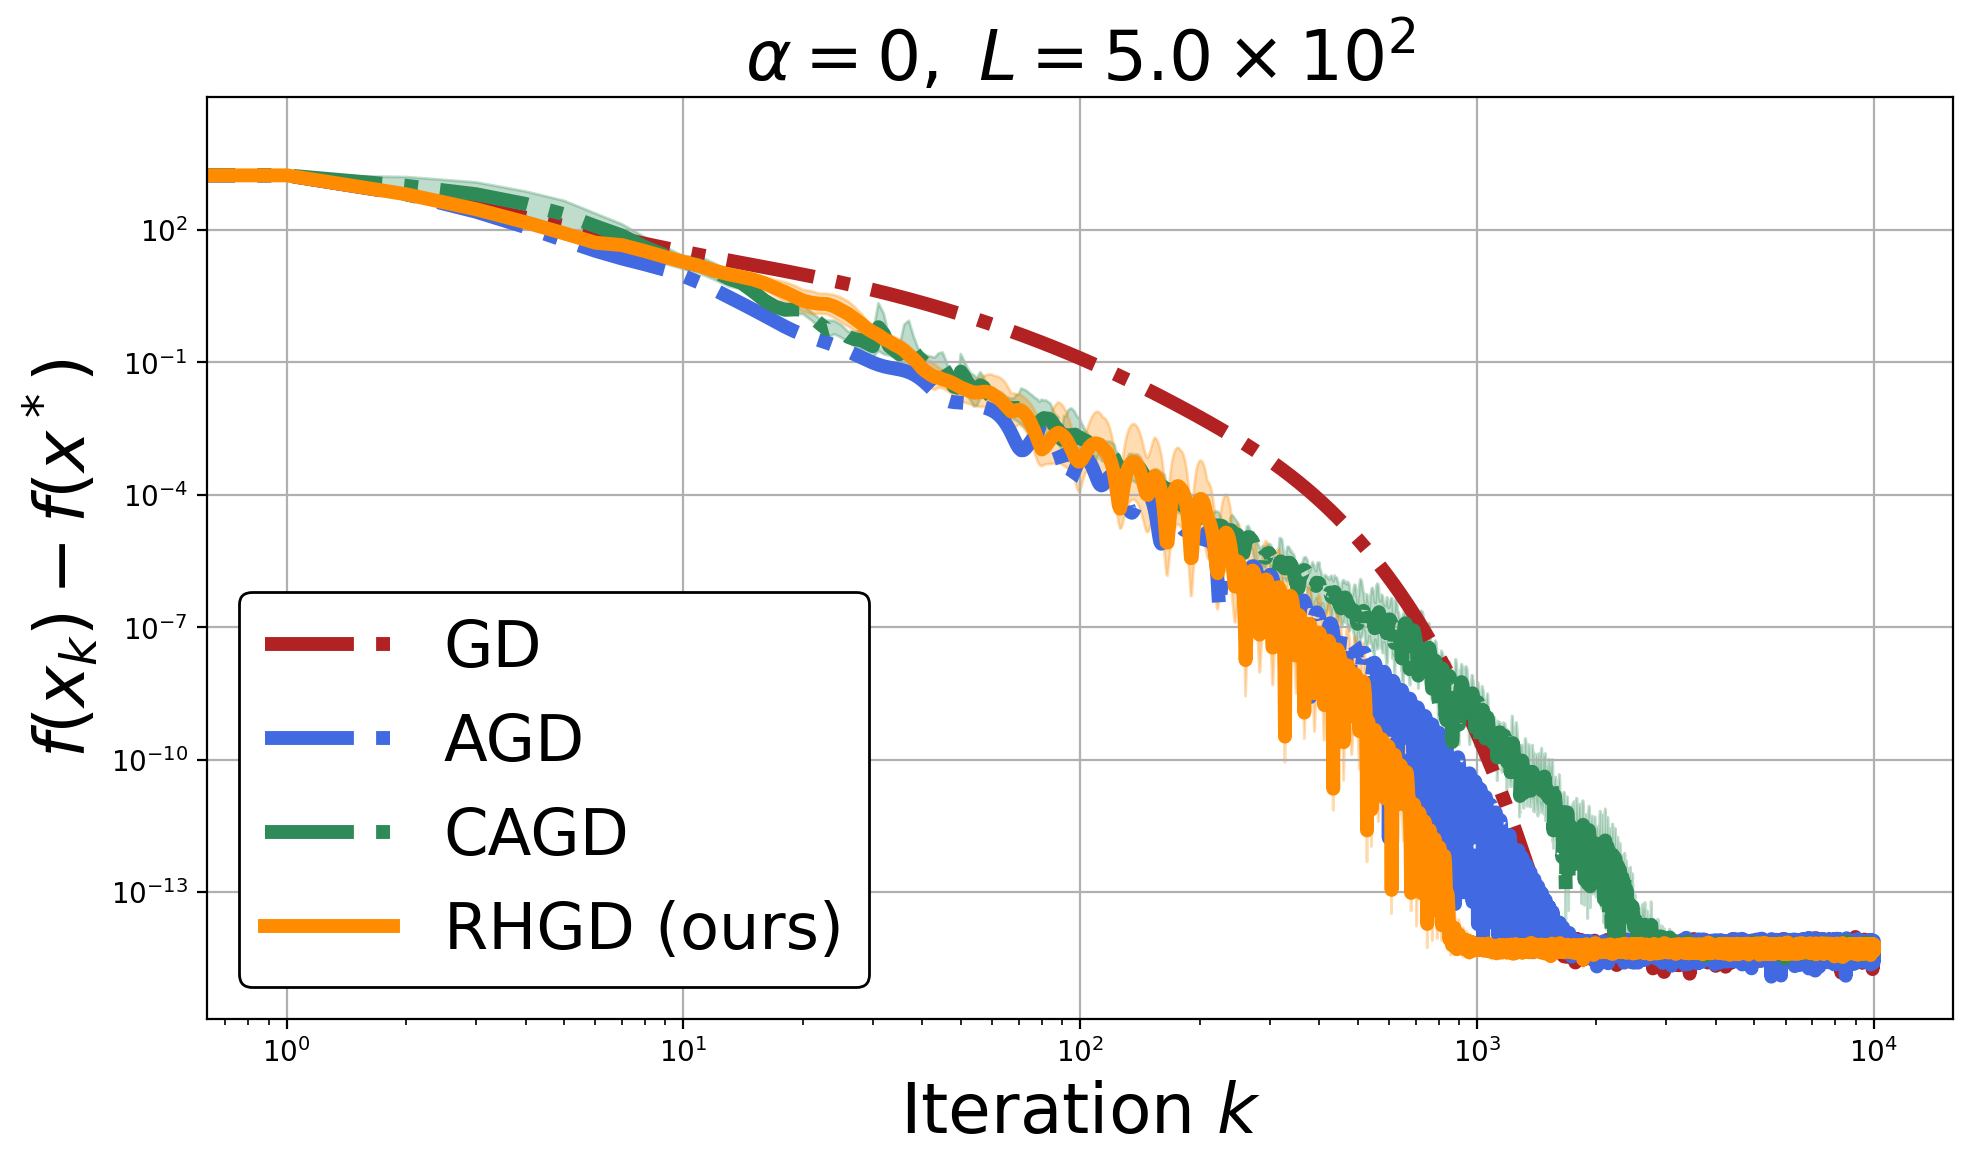

In [13]:
#Minimizing weakly convex quadratic functions
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
plt.style.use('default')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

np.random.seed(42)
dim = 100
x0 = np.random.randn(dim)
num_iters = int(1e4)     # Number of iterations

#generate matrix with smallest eigenvalue 0 and user-specified largest eigenvalue
def generate_symmetric_matrix_with_zero_min_eig(dim, lambda_max, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Step 1: Create a random orthogonal matrix Q
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))

    # Step 2: Define desired eigenvalues
    eigvals = np.linspace(0, lambda_max, dim)
    eigvals[-1] = lambda_max  # make sure one is exactly lambda_max
    eigvals[0] = 0            # make sure one is exactly zero

    # Step 3: Construct matrix
    A = Q @ np.diag(eigvals) @ Q.T

    # Force symmetry to reduce numerical noise
    A = 0.5 * (A + A.T)

    return A

def format_sci_latex(val):
    coeff = val / (10 ** int(np.floor(np.log10(val))))
    exp = int(np.floor(np.log10(val)))
    return rf'{coeff:.1f}\times 10^{{{exp}}}'

lamda_max = 500 # We test 500, 5000 and 50000
A = generate_symmetric_matrix_with_zero_min_eig(dim, lamda_max, seed=42)
L = lamda_max


def quad_loss(x):
    return 0.5 * x @ A @ x

def quad_grad(x):
    return A @ x

# Standard Gradient Descent (GD)
def run_gd(x0, num_iters, gamma):
    x = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_new = x - gamma * quad_grad(x)
        x = x_new
    return x, losses

# Nesterov's Accelerated Gradient Descent (NAG) for weakly convex functions
def run_nag(x0, num_iters, gamma):
    x = x0.copy()
    y = x0.copy()
    t = 1.0
    losses = []
    for _ in range(num_iters):
        losses.append(quad_loss(x))
        x_new = y - gamma * quad_grad(y)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2  # update t_{k+1}
        y = x_new + ((t - 1) / t_new) * (x_new - x)
        x, t = x_new, t_new
    return x, losses

#CAGD for weakly convex functions
def stochastic_accelerated_descent(x0, gamma, num_iters, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    d = len(x0)
    x = x0.copy()
    z = x0.copy()
    x_list = [x.copy()]
    fx_list = []

    # Sample T_1, ..., T_{num_iters+1} as partial sums of exponential RVs
    Tk = np.cumsum(rng.exponential(scale=1.0, size=num_iters + 1))

    for k in range(num_iters):
        fx_list.append(quad_loss(x))
        tau_k = 1 - (Tk[k] / Tk[k+1]) ** 2
        tau_k_prime = 0
        gamma_k = gamma
        gamma_k_prime = Tk[k] * gamma / 2

        y = x + tau_k * (z - x)
        x_next = y - gamma_k * quad_grad(y)
        z_next = z + tau_k_prime * (y - z) - gamma_k_prime * quad_grad(y)

        x = x_next
        z = z_next

    return x, fx_list


#RHGD for weakly convex functions
def run_rhgd(x0, num_iters, h, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    for k in range(num_iters):
        losses.append(quad_loss(x))
        x_half = x + h * y
        x_new = x_half - (h ** 2) * quad_grad(x_half)
        y_tilde = y - h * quad_grad(x_new)
        prob = 17 / (2 * k + 18)
        if rng.random() < prob:
           y = np.zeros(dim)
        else:
           y = y_tilde
        x = x_new
    return x, losses

#generate error bar
def compute_log_curve_stats(losses_all):
    """
    Given a list of loss curves (each is a list of floats), compute:
    - mean loss
    - log10(mean)
    - log-scale std shading (upper/lower curve)
    Returns a dictionary of log10(mean), upper/lower envelope in log space, and original loss envelope.
    """
    mean_loss = np.mean(losses_all, axis=0)
    logmean = np.log10(mean_loss)
    std_loss = np.std(losses_all, axis=0)
    logstd = std_loss / (mean_loss * np.log(10))  # delta(log10(x)) ≈ std/x * 1/ln(10)

    log_lower = logmean - logstd
    log_upper = logmean + logstd
    lower = 10 ** log_lower
    upper = 10 ** log_upper

    return mean_loss, lower, upper

eta = 2e-3 #See Table 3 for the optimal stepsize for L=5000 and 50000
h = np.sqrt(eta)
losses_gd_all, losses_nag_all, losses_cnag_all, losses_rhgd_all = [], [], [], []

for i in range(5):
    rng = np.random.default_rng(seed=i)
    _, lcnag = stochastic_accelerated_descent(x0, eta, num_iters, rng=rng)
    _, lrhgd = run_rhgd(x0, num_iters, h, rng=rng)
    losses_cnag_all.append(lcnag)
    losses_rhgd_all.append(lrhgd)

_, lgd = run_gd(x0, num_iters, eta)
_, lnag = run_nag(x0, num_iters, eta)
losses_cnag_all = np.array(losses_cnag_all)
losses_rhgd_all = np.array(losses_rhgd_all)

# error bar
mean_cnag, lower_cnag, upper_cnag = compute_log_curve_stats(losses_cnag_all)
mean_rhgd, lower_rhgd, upper_rhgd = compute_log_curve_stats(losses_rhgd_all)

for loss_curve in [lgd, lnag, mean_cnag, mean_rhgd]:
  loss_curve[0] = quad_loss(x0)

iters = np.arange(num_iters)
plt.figure(figsize=(10, 6))

plt.plot(iters, lgd, linestyle='-.', label='GD', color='firebrick', linewidth=5)
plt.plot(iters, lnag, linestyle='-.', label='AGD', color='royalblue', linewidth=5)
plt.plot(iters, mean_cnag, linestyle='-.', label='CAGD', color='seagreen', linewidth=5)
plt.fill_between(iters, lower_cnag, upper_cnag, color='seagreen', alpha=0.3)
plt.plot(iters, mean_rhgd, label='RHGD (ours)', color='darkorange', linewidth=5)
plt.fill_between(iters, lower_rhgd, upper_rhgd, color='darkorange', alpha=0.3)

plt.xlabel(r'Iteration $k$', fontsize=25)
plt.ylabel(r'$f(x_k)-f(x^*)$', fontsize=25)
plt.title(rf'$\alpha=0,\ L={format_sci_latex(L)}$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend(
fontsize=23,
frameon=True,
fancybox=True,
facecolor='white',
edgecolor='black',
framealpha=1.0)
plt.tight_layout()
plt.show()

<ipython-input-6-8f63a80f63e7>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


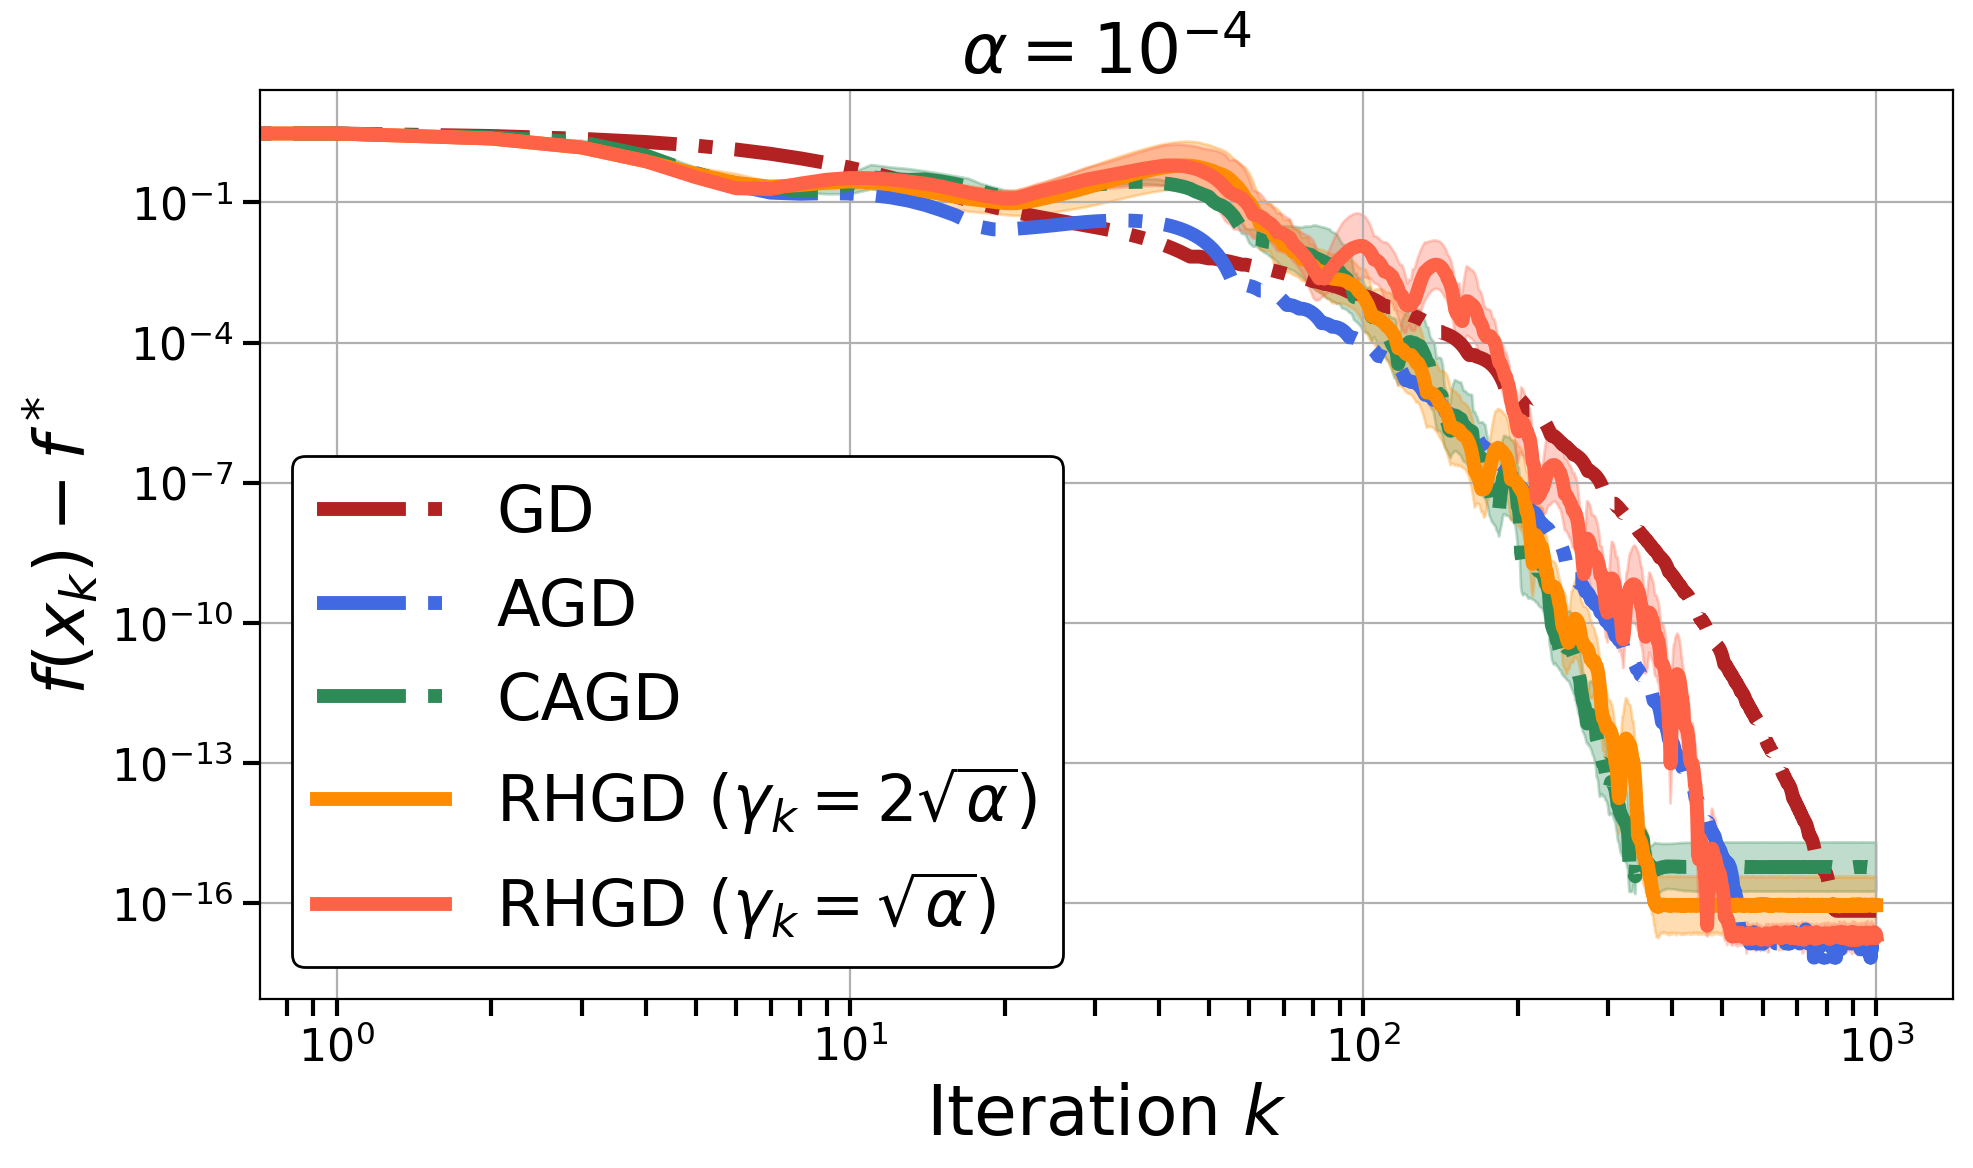

In [6]:
#Logistic Regression + L2 adaptive (strongly convex)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
plt.style.use('default')
set_matplotlib_formats('retina')

np.random.seed(42)
# Problem parameters
dim = 100              # Feature dimension
num_samples = 500        # Number of data points (toy example)
num_iters = int(1e3)       # Number of iterations

lambda_reg = 1e-4   # L2 regularization strength. we test 1e-3, 1e-4 and 1e-5
x0 = np.random.randn(dim)
# Generate synthetic data for logistic regression
A = np.random.randn(num_samples, dim)
true_x = np.random.randn(dim)
b = np.sign(A @ true_x + 0.1 * np.random.randn(num_samples))
alpha = lambda_reg


def logistic_loss(x):
    exp_term = np.exp(-b * (A @ x))
    return np.mean(np.log(1 + exp_term)) + (lambda_reg / 2) * np.linalg.norm(x)**2

def logistic_grad(x):
    exp_term = np.exp(b * (A @ x))
    return - (A.T @ (b / (1 + exp_term))) / num_samples + lambda_reg * x

def compute_log_curve_stats(losses_all, f_star=None):
    """
    Given a list of loss curves (each is a list of floats), compute:
    - mean loss (optionally shifted by f_star)
    - log10(mean)
    - log-scale std shading (upper/lower curve)

    Parameters:
    - losses_all: array-like, shape (n_trials, n_iters)
    - f_star: float or None, minimum loss value to subtract from all losses (e.g., estimated f(x*))

    Returns:
    - mean_loss, lower_bound, upper_bound: arrays of length n_iters
    """
    losses_all = np.array(losses_all)

    if f_star is not None:
        shifted = losses_all - f_star
        shifted = np.clip(shifted, 1e-20, None)  # avoid log(0)
    else:
        shifted = losses_all

    mean_loss = np.mean(shifted, axis=0)
    std_loss = np.std(shifted, axis=0)

    logmean = np.log10(mean_loss)
    logstd = std_loss / (mean_loss * np.log(10))  # delta(log10(x)) ≈ std/x * 1/ln(10)

    log_lower = logmean - logstd
    log_upper = logmean + logstd

    lower = 10 ** log_lower
    upper = 10 ** log_upper

    return mean_loss, lower, upper


# Ada-GD
def run_gd(x0, num_iters, gamma):
    x = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(logistic_loss(x))
        x_trial = x - gamma * logistic_grad(x)
        if logistic_loss(x_trial) <= logistic_loss(x) - (gamma / 2) * np.linalg.norm(logistic_grad(x))**2:
          gamma = 1.1 * gamma
          x_new = x_trial
        else:
          gamma = 0.6 * gamma
          x_new = x
        x = x_new
    return x, losses


# Ada-AGD for strongly convex functions
def run_nag(x0, num_iters, gamma, mu):
    x = x0.copy()
    y = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(logistic_loss(x))
        x_old = x.copy()
        x_trial = y - gamma * logistic_grad(y)
        if logistic_loss(x_trial) <= logistic_loss(y) - (gamma / 2) * np.linalg.norm(logistic_grad(y))**2:
          gamma = 1.1 * gamma
          x = x_trial
        else:
          gamma = 0.6 * gamma
          x = x_old
        kappa = 1 / (gamma * mu)
        theta = (np.sqrt(kappa) - 1) / (np.sqrt(kappa) + 1)
        y_new = x + theta * (x - x_old)

        y = y_new
    return x, losses

#Ada-CAGD for strongly convex functions
def stochastic_accelerated_descent(x0, gamma, mu, num_iters, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    d = len(x0)
    x = x0.copy()
    z = x0.copy()
    x_list = [x.copy()]
    fx_list = []

    # Sample T_1, ..., T_{num_iters+1} as partial sums of exponential RVs
    T = np.cumsum(rng.exponential(scale=1.0, size=num_iters + 1))
    for k in range(num_iters):
        fx_list.append(logistic_loss(x))
        sqrt_mu_L = np.sqrt(mu * gamma)
        delta_t = T[k+1] - T[k]
        tau_k = 0.5 * (1 - np.exp(-2 * sqrt_mu_L * delta_t))
        gamma_k = gamma

        y = x + tau_k * (z - x)
        x_trial = y - gamma_k * logistic_grad(y)
        if logistic_loss(x_trial) <= logistic_loss(y) - (gamma_k / 2) * np.linalg.norm(logistic_grad(y))**2:
          gamma = 1.1 * gamma
          x_next = x_trial
        else:
          gamma = 0.6 * gamma
          x_next = x
        sqrt_mu_L = np.sqrt(mu * gamma)
        tau_k_prime = np.tanh(sqrt_mu_L * delta_t)
        gamma_k_prime = np.sqrt(gamma) / np.sqrt(mu)
        z_next = z + tau_k_prime * (y - z) - gamma_k_prime * logistic_grad(y)

        x = x_next
        z = z_next

    return x, fx_list

#Ada-RHGD for strongly convex functions
def run_rhgd(x0, num_iters, h, mu, c, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    for k in range(num_iters):
        losses.append(logistic_loss(x))
        x_half = x + h * y
        x_trial = x_half - (h ** 2) * logistic_grad(x_half)

        if logistic_loss(x_trial) <= logistic_loss(x_half) - (h**2 / 2) * np.linalg.norm(logistic_grad(x_half))**2:
          h = np.sqrt(1.1) * h
          x_new = x_trial
        else:
          h = np.sqrt(0.6) * h
          x_new = x

        y_tilde = y - h * logistic_grad(x_new)
        prob = np.sqrt(mu) * h * c
        if rng.random() < prob:
           y = np.zeros(dim)
        else:
           y = y_tilde

        x = x_new
    return x, losses


eta = 1 #initialization
h = np.sqrt(eta)

losses_gd_all, losses_nag_all, losses_cnag_all, losses_rhed_all, losses_rhgd_all, losses_rhgd1_all = [], [], [], [], [], []

for i in range(5):
    rng = np.random.default_rng(seed=i)
    _, lrhgd = run_rhgd(x0, num_iters, h, alpha, 2, rng=rng)
    _, lrhgd1 = run_rhgd(x0, num_iters, h, alpha, 1, rng=rng)
    _, lcnag = stochastic_accelerated_descent(x0, eta, alpha, num_iters, rng=rng)
    losses_rhgd_all.append(lrhgd)
    losses_rhgd1_all.append(lrhgd1)
    losses_cnag_all.append(lcnag)

_, lgd = run_gd(x0, num_iters, eta)
_, lnag = run_nag(x0, num_iters, eta, alpha)
losses_cnag_all = np.array(losses_cnag_all)
losses_rhgd_all = np.array(losses_rhgd_all)
losses_rhgd1_all = np.array(losses_rhgd1_all)

#Estimate the minimum
f_star = np.min(np.concatenate([
losses_rhgd_all,
losses_rhgd1_all,
losses_cnag_all,
[lgd],
[lnag]]))

mean_cnag, lower_cnag, upper_cnag = compute_log_curve_stats(losses_cnag_all, f_star=f_star)
mean_rhgd, lower_rhgd, upper_rhgd = compute_log_curve_stats(losses_rhgd_all, f_star=f_star)
mean_rhgd1, lower_rhgd1, upper_rhgd1 = compute_log_curve_stats(losses_rhgd1_all, f_star=f_star)

for loss_curve in [lgd, lnag, mean_cnag, mean_rhgd, mean_rhgd1]:
  loss_curve[0] = logistic_loss(x0)

iters = np.arange(num_iters)
plt.figure(figsize=(10, 6))

plt.plot(iters, lgd-f_star, linestyle='-.', label='GD', color='firebrick', linewidth=5)
plt.plot(iters, lnag-f_star, linestyle='-.', label='AGD', color='royalblue', linewidth=5)
plt.plot(iters, mean_cnag, linestyle='-.', label='CAGD', color='seagreen', linewidth=5)
plt.fill_between(iters, lower_cnag, upper_cnag, color='seagreen', alpha=0.3)
plt.plot(iters, mean_rhgd, label=r'RHGD ($\gamma_k=2\sqrt{\alpha}$)', color='darkorange', linewidth=5)
plt.fill_between(iters, lower_rhgd, upper_rhgd, color='darkorange', alpha=0.3)
plt.plot(iters, mean_rhgd1, label=r'RHGD ($\gamma_k=\sqrt{\alpha}$)', color='tomato', linewidth=5)
plt.fill_between(iters, lower_rhgd1, upper_rhgd1, color='tomato', alpha=0.3)

plt.xlabel(r'Iteration $k$', fontsize=25)
plt.ylabel(r'$f(x_k)-f^*$', fontsize=25)
plt.title(rf'$\alpha = 10^{{{int(np.log10(lambda_reg))}}}$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tick_params(
axis='both',
which='both',
labelsize=16,
length=6,
width=1.5)
plt.legend(
fontsize=23,
frameon=True,
fancybox=True,
facecolor='white',
edgecolor='black',
framealpha=1.0)
plt.tight_layout()
plt.show()


<ipython-input-11-77915b3b949e>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


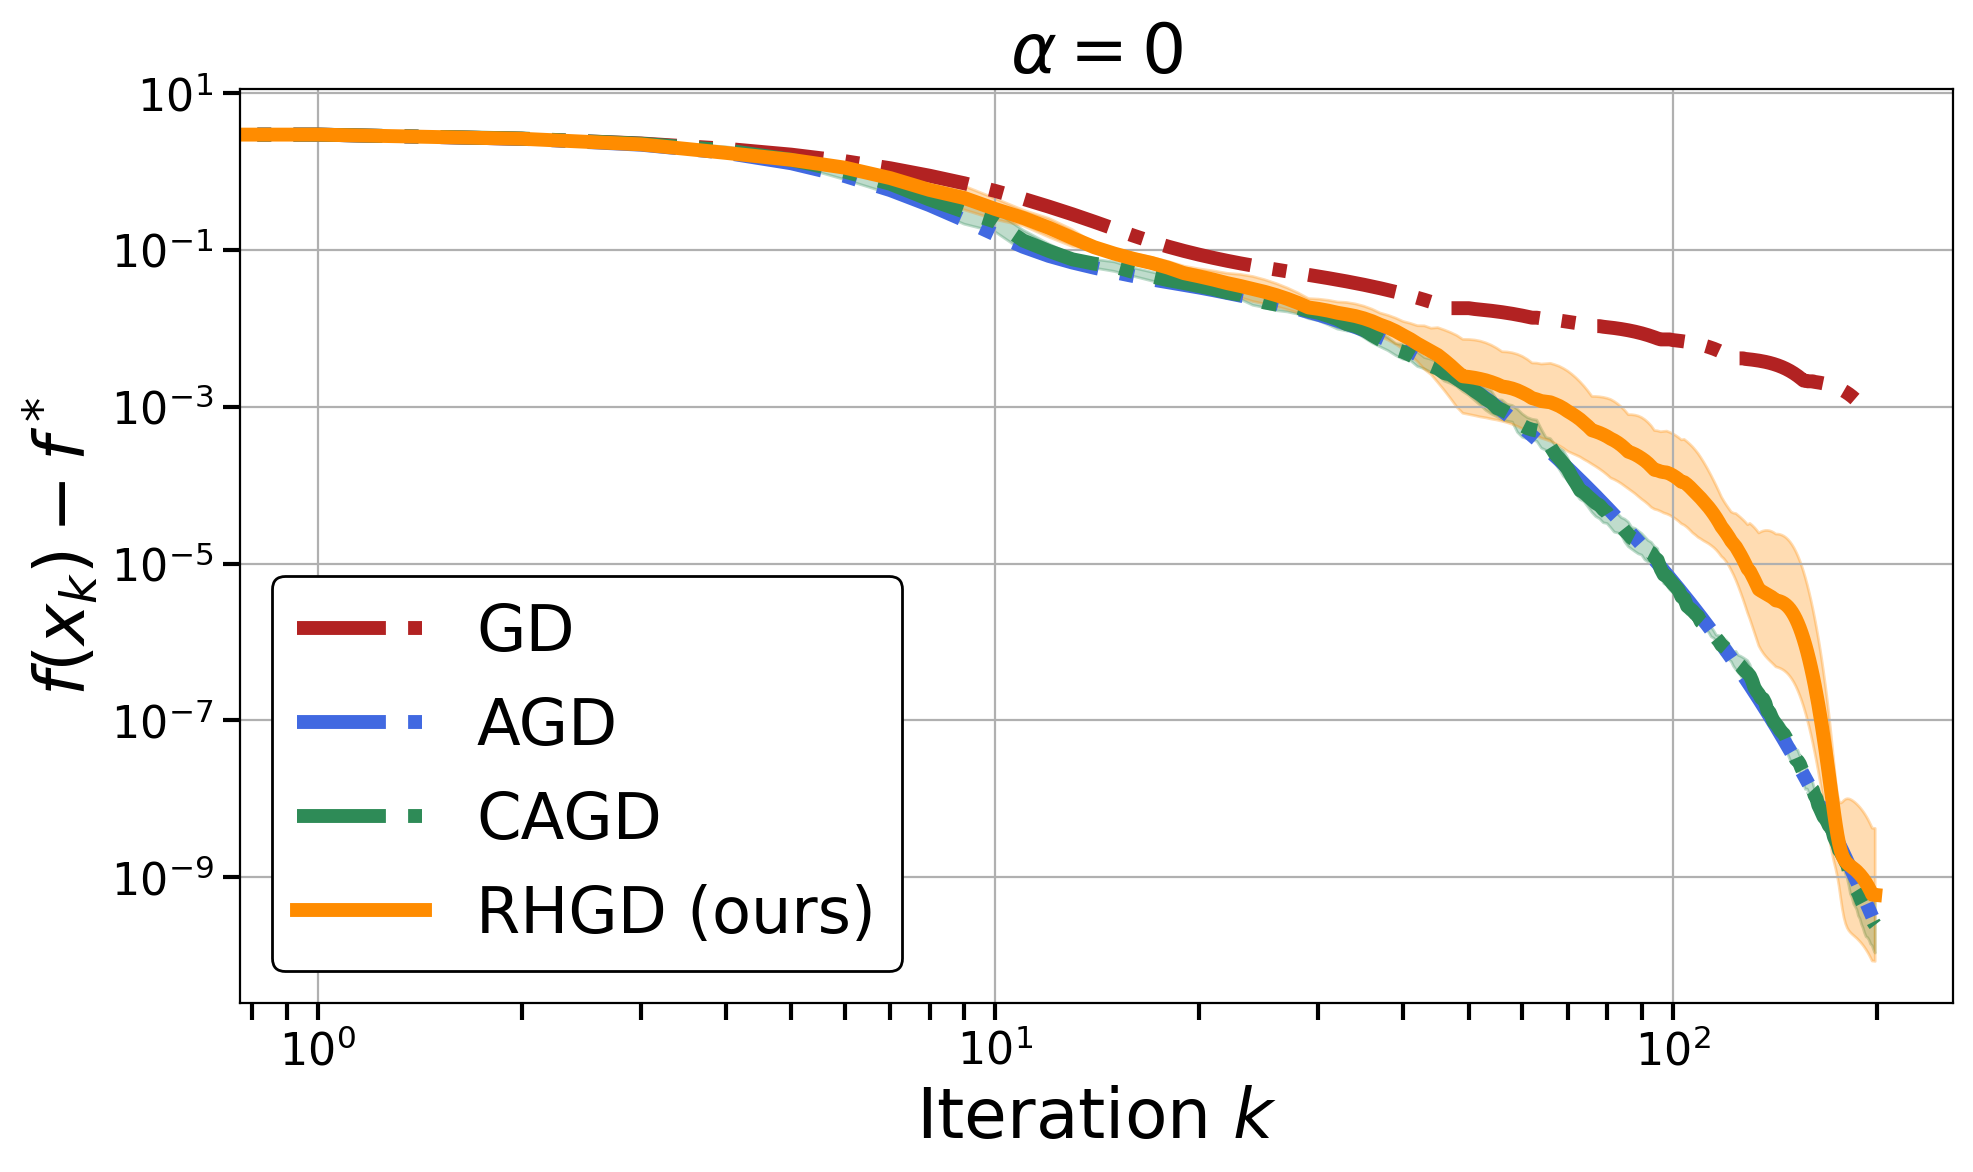

In [11]:
#Logistic Regression + adaptive stepize (weakly convex)
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
plt.style.use('default')
set_matplotlib_formats('retina')


# Problem parameters
dim = 100              # Feature dimension
num_samples = 500        # Number of data points (toy example)
num_iters = int(2e2)       # Number of iterations

np.random.seed(42)
x0 = np.random.randn(dim)
# Generate synthetic data for logistic regression
A = np.random.randn(num_samples, dim)
true_x = np.random.randn(dim)
b = np.sign(A @ true_x + 0.1 * np.random.randn(num_samples))


def logistic_loss(x):
    exp_term = np.exp(-b * (A @ x))
    return np.mean(np.log(1 + exp_term))

def logistic_grad(x):
    exp_term = np.exp(b * (A @ x))
    return - (A.T @ (b / (1 + exp_term))) / num_samples

# Ada-GD
def run_gd(x0, num_iters, gamma):
    x = x0.copy()
    losses = []
    for _ in range(num_iters):
        losses.append(logistic_loss(x))
        x_trial = x - gamma * logistic_grad(x)
        if logistic_loss(x_trial) <= logistic_loss(x) - (gamma / 2) * np.linalg.norm(logistic_grad(x))**2:
          gamma = 1.1 * gamma
          x_new = x_trial
        else:
          gamma = 0.6 * gamma
          x_new = x
        x = x_new
    return x, losses

# Ada-AGD for weakly convex functions
def run_nag(x0, num_iters, gamma):
    x = x0.copy()
    y = x0.copy()
    t = 1.0
    losses = []
    for _ in range(num_iters):
        losses.append(logistic_loss(x))
        x_trial = y - gamma * logistic_grad(y)
        if logistic_loss(x_trial) <= logistic_loss(y) - (gamma / 2) * np.linalg.norm(logistic_grad(y))**2:
          gamma = 1.1 * gamma
          x_new = x_trial
        else:
          gamma = 0.6 * gamma
          x_new = x
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2  # update t_{k+1}
        y_new = x_new + ((t - 1) / t_new) * (x_new - x)

        x, y, t = x_new, y_new, t_new
    return x, losses

def stochastic_accelerated_descent(x0, gamma, num_iters, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    d = len(x0)
    x = x0.copy()
    z = x0.copy()
    x_list = [x.copy()]
    fx_list = []

    # Sample T_1, ..., T_{num_iters+1} as partial sums of exponential RVs
    Tk = np.cumsum(rng.exponential(scale=1.0, size=num_iters + 1))

    for k in range(num_iters):
        fx_list.append(logistic_loss(x))
        tau_k = 1 - (Tk[k] / Tk[k+1]) ** 2
        tau_k_prime = 0
        gamma_k = gamma


        y = x + tau_k * (z - x)
        x_trial = y - gamma_k * logistic_grad(y)
        if logistic_loss(x_trial) <= logistic_loss(y) - (gamma_k / 2) * np.linalg.norm(logistic_grad(y))**2:
          gamma = 1.1 * gamma
          x_next = x_trial
        else:
          gamma = 0.6 * gamma
          x_next = x
        gamma_k_prime = Tk[k] * gamma / 2
        z_next = z + tau_k_prime * (y - z) - gamma_k_prime * logistic_grad(y)

        x = x_next
        z = z_next

    return x, fx_list


#Ada-RHGD for weakly convex functions
def run_rhgd(x0, num_iters, h, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    for k in range(num_iters):
        losses.append(logistic_loss(x))
        x_half = x + h * y
        x_trial = x_half - (h ** 2) * logistic_grad(x_half)
        if logistic_loss(x_trial) <= logistic_loss(x_half) - (h**2 / 2) * np.linalg.norm(logistic_grad(x_half))**2:
          h = np.sqrt(1.1) * h
          x_new = x_trial
        else:
          h = np.sqrt(0.6) * h
          x_new = x
        y_tilde = y - h * logistic_grad(x_new)
        prob = 17 / (2*k + 18)
        if rng.random() < prob:
           y = np.zeros(dim)
        else:
           y = y_tilde
        x = x_new
    return x, losses


def compute_log_curve_stats(losses_all):
    """
    Given a list of loss curves (each is a list of floats), compute:
    - mean loss
    - log10(mean)
    - log-scale std shading (upper/lower curve)
    Returns a dictionary of log10(mean), upper/lower envelope in log space, and original loss envelope.
    """
    mean_loss = np.mean(losses_all, axis=0)
    logmean = np.log10(mean_loss)
    std_loss = np.std(losses_all, axis=0)
    logstd = std_loss / (mean_loss * np.log(10))  # delta(log10(x)) ≈ std/x * 1/ln(10)

    log_lower = logmean - logstd
    log_upper = logmean + logstd
    lower = 10 ** log_lower
    upper = 10 ** log_upper

    return mean_loss, lower, upper

eta = 1 #initialization
h = np.sqrt(eta)

losses_gd_all, losses_nag_all, losses_cnag_all, losses_rhgd_all, losses_rhgd1_all = [], [], [], [], []

for i in range(5):
    rng = np.random.default_rng(seed=i)
    _, lrhgd = run_rhgd(x0, num_iters, h, rng=rng)
    _, lcnag = stochastic_accelerated_descent(x0, eta, num_iters, rng=rng)
    losses_rhgd_all.append(lrhgd)
    losses_cnag_all.append(lcnag)


_, lgd = run_gd(x0, num_iters, eta)
_, lnag = run_nag(x0, num_iters, eta)
losses_cnag_all = np.array(losses_cnag_all)
losses_rhgd_all = np.array(losses_rhgd_all)

# error bar
mean_cnag, lower_cnag, upper_cnag = compute_log_curve_stats(losses_cnag_all)
mean_rhgd, lower_rhgd, upper_rhgd = compute_log_curve_stats(losses_rhgd_all)

for loss_curve in [lgd, lnag, mean_cnag, mean_rhgd]:
  loss_curve[0] = logistic_loss(x0)

iters = np.arange(num_iters)
plt.figure(figsize=(10, 6))

plt.plot(iters, lgd, linestyle='-.', label='GD', color='firebrick', linewidth=5)
plt.plot(iters, lnag, linestyle='-.', label='AGD', color='royalblue', linewidth=5)
plt.plot(iters, mean_cnag, linestyle='-.', label='CAGD', color='seagreen', linewidth=5)
plt.fill_between(iters, lower_cnag, upper_cnag, color='seagreen', alpha=0.3)
plt.plot(iters, mean_rhgd, label=r'RHGD (ours)', color='darkorange', linewidth=5)
plt.fill_between(iters, lower_rhgd, upper_rhgd, color='darkorange', alpha=0.3)

plt.xlabel(r'Iteration $k$', fontsize=25)
plt.ylabel(r'$f(x_k)-f^*$', fontsize=25)
plt.title(rf'$\alpha=0$', fontsize=25)
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tick_params(
axis='both',
which='both',
labelsize=16,
length=6,
width=1.5
)
plt.legend(fontsize=20)
plt.legend(
fontsize=23,
frameon=True,
fancybox=True,
facecolor='white',
edgecolor='black',
framealpha=1.0)
plt.tight_layout()
#plt.savefig("logiC.png", bbox_inches='tight', dpi=300)
plt.show()

<ipython-input-10-0d0075d0b1f3>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


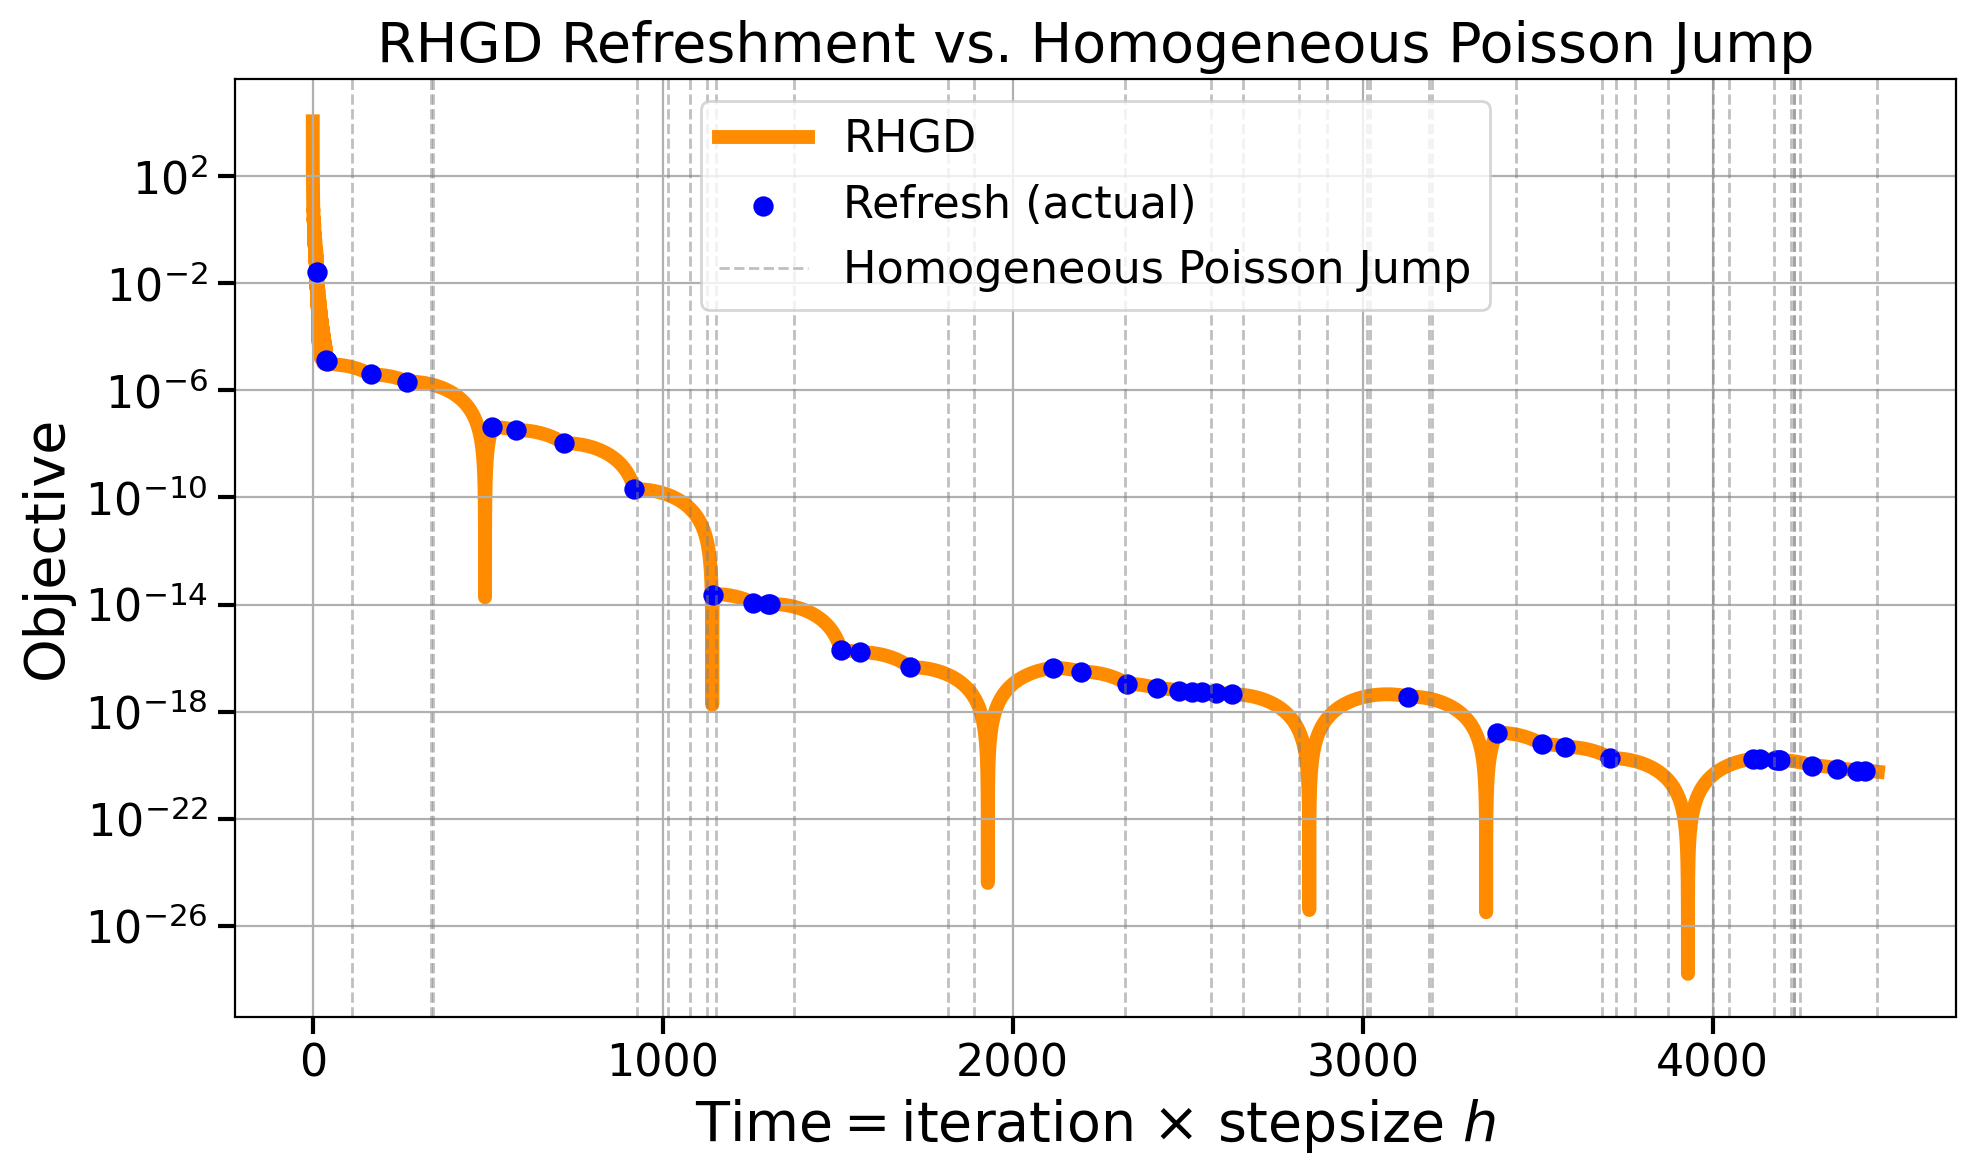

In [10]:
# Mark refreshment s-c
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

np.random.seed(42)
dim = 100
x0 = np.random.randn(dim)
num_iters = int(1e5)     # Number of iterations

def generate_spd_matrix_fixed_max(dim, cond_num, lambda_max):
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))
    lambda_min = lambda_max / cond_num
    eigvals = np.linspace(lambda_max, lambda_min, dim)
    A = Q @ np.diag(eigvals) @ Q.T
    return A

kappa = 1e7
# Generate synthetic data for logistic regression
A = generate_spd_matrix_fixed_max(dim, kappa, 500)
alpha = 500 / kappa

def quad_loss(x):
    return 0.5 * x @ A @ x

def quad_grad(x):
    return A @ x

def run_rhgd(x0, num_iters, h, mu, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    refresh_points = []
    for k in range(num_iters):
        losses.append(quad_loss(x))
        x_half = x + h * y
        x_new = x_half - (h ** 2) * quad_grad(x_half)
        y_tilde = y - h * quad_grad(x_new)
        prob = np.sqrt(mu) * h
        if rng.random() < prob:
           y = np.zeros(dim)
           refresh_points.append(k)
        else:
           y = y_tilde
        x = x_new
    return x, losses, refresh_points



def plot_rhed_vs_poisson_refresh(losses, refresh_points, h, mu, label='RHGD'):
    """
    Plots RHGD loss curve with actual refresh points and Poisson jump times on the same x-axis.

    Parameters:
    - losses: list of loss values from RHGD
    - refresh_points: list of iteration indices where refresh happened
    - h: step size used in RHGD (for computing time)
    - mu: parameter for Poisson rate, lambda = 2 * sqrt(mu)
    - label: label for the loss curve
    """

    num_iters = len(losses)
    time_points = np.arange(num_iters) * h  # RHED time axis

    # Compute Poisson jump times
    rate = np.sqrt(mu)
    T_max = time_points[-1]
    poisson_jumps = []
    t = 0
    while t < T_max:
        dt = np.random.exponential(scale=1 / rate)
        t += dt
        poisson_jumps.append(t)

    # Get actual refresh time and loss value
    refresh_times = [time_points[i] for i in refresh_points]
    refresh_losses = [losses[i] for i in refresh_points]

    # Start plotting
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, losses, label=label, color='darkorange', linewidth=5, zorder=1)

    plt.scatter(refresh_times, refresh_losses, color='blue', s=40, label='Refresh (actual)', zorder=2)

    for i, t in enumerate(poisson_jumps):
        if t <= T_max:
            plt.axvline(x=t, color='gray', linestyle='--', linewidth=1, alpha=0.5,
                        label='Homogeneous Poisson Jump' if i == 0 else "")

    plt.xlabel(r"Time$=$iteration $\times$ stepsize $h$", fontsize=20)
    plt.ylabel(r"Objective", fontsize=20)
    plt.yscale("log")
    plt.grid(True)
    plt.tick_params(
    axis='both',
    which='both',
    labelsize=16,
    length=6,
    width=1.5)
    plt.legend(
    fontsize=23,
    frameon=True,
    fancybox=True,
    facecolor='white',
    edgecolor='black',
    framealpha=1.0)
    plt.title("RHGD Refreshment vs. Homogeneous Poisson Jump", fontsize=20)
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


gamma = 2e-3
h = np.sqrt(gamma)
se = np.random.default_rng(seed=0)
_, lrhgd, refresh1 = run_rhgd(x0, num_iters, h, alpha, rng=se)
plot_rhed_vs_poisson_refresh(lrhgd, refresh1, h, alpha, label='RHGD')

<ipython-input-7-26aab8fd2760>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


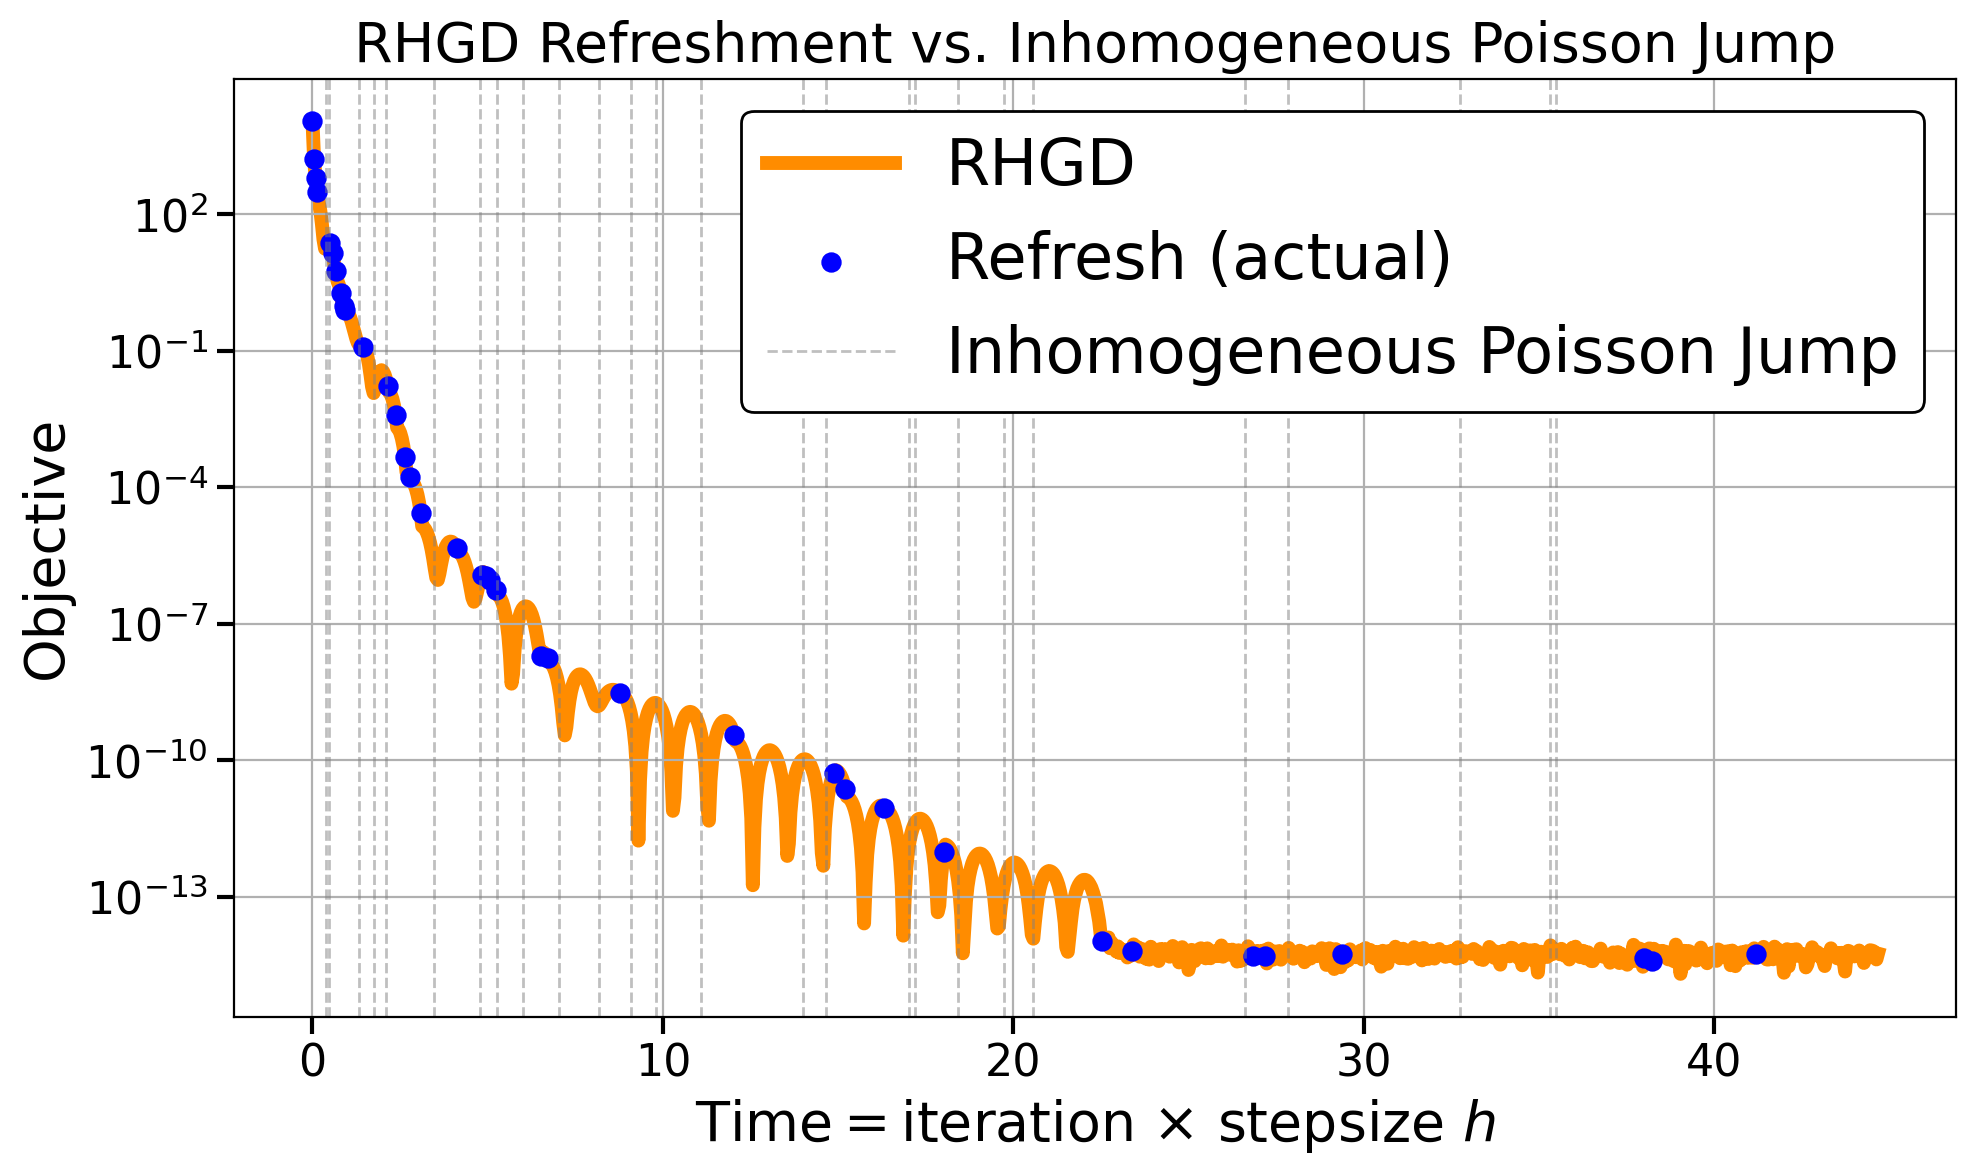

In [7]:
#Mark refreshment under weak convexity
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
plt.style.use('default')
set_matplotlib_formats('retina')

np.random.seed(42)
dim = 100
x0 = np.random.randn(dim)

num_iters = int(1e3)     # Number of iterations

def generate_symmetric_matrix_with_zero_min_eig(dim, lambda_max, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Step 1: Create a random orthogonal matrix Q
    Q, _ = np.linalg.qr(np.random.randn(dim, dim))

    # Step 2: Define desired eigenvalues
    eigvals = np.linspace(0, lambda_max, dim)
    eigvals[-1] = lambda_max  # make sure one is exactly lambda_max
    eigvals[0] = 0            # make sure one is exactly zero

    # Step 3: Construct matrix
    A = Q @ np.diag(eigvals) @ Q.T

    # Force symmetry to reduce numerical noise
    A = 0.5 * (A + A.T)

    return A

A = generate_symmetric_matrix_with_zero_min_eig(dim, 500, seed=42)

mu = np.min(np.linalg.eigvalsh(A))
L = np.max(np.linalg.eigvalsh(A))

def quad_loss(x):
    return 0.5 * x @ A @ x

def quad_grad(x):
    return A @ x

def run_rhgd(x0, num_iters, h, L, rng=None):
    if rng is None:
      rng = np.random.default_rng()
    x = x0.copy()
    y = np.zeros(dim)
    losses = []
    refresh_points = []
    for k in range(num_iters):
        losses.append(quad_loss(x))
        x_half = x + h * y
        x_new = x_half - (h ** 2) * quad_grad(x_half)
        y_tilde = y - h * quad_grad(x_new)
        prob = 17 / (2 * k + 18)
        if rng.random() < prob:
           y = np.zeros(dim)
           refresh_points.append(k)
        else:
           y = y_tilde
        x = x_new
    return x, losses, refresh_points

def simulate_inhomogeneous_poisson(T_max, h, lambda_max=1.0):
    """
    Simulate an inhomogeneous Poisson process with rate λ(t) = 1 / (t + 2h)
    using the thinning method.

    Returns a list of jump times in [0, T_max].
    """
    t = 0
    jump_times = []

    while t < T_max:
        # Step 1: Propose next jump using homogeneous Poisson with rate = lambda_max
        u = np.random.exponential(1 / lambda_max)
        t += u

        if t >= T_max:
            break

        # Step 2: Accept with probability λ(t) / λ_max
        lambda_t = 17 / (2 * t + 18 * h)
        if np.random.rand() < lambda_t / lambda_max:
            jump_times.append(t)

    return jump_times

def plot_rhed_vs_inhomogeneous_poisson(losses, refresh_points, h, label='RHGD'):
    num_iters = len(losses)
    time_points = np.arange(num_iters) * h
    T_max = time_points[-1]

    # Simulate inhomogeneous Poisson jump times
    poisson_jumps = simulate_inhomogeneous_poisson(T_max, h)

    #
    refresh_times = [time_points[i] for i in refresh_points]
    refresh_losses = [losses[i] for i in refresh_points]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, losses, label=label, color='darkorange', linewidth=5, zorder=1)
    plt.scatter(refresh_times, refresh_losses, color='blue', s=40, label='Refresh (actual)', zorder=2)

    for i, t in enumerate(poisson_jumps):
        plt.axvline(x=t, color='gray', linestyle='--', linewidth=1, alpha=0.5,
                    label='Inhomogeneous Poisson Jump' if i == 0 else "")

    plt.xlabel(r"Time$=$iteration $\times$ stepsize $h$", fontsize=20)
    plt.ylabel("Objective", fontsize=20)
    plt.yscale("log")
    plt.grid(True)
    plt.tick_params(
    axis='both',
    which='both',
    labelsize=16,
    length=6,
    width=1.5)
    plt.legend(
    fontsize=23,
    frameon=True,
    fancybox=True,
    facecolor='white',
    edgecolor='black',
    framealpha=1.0)
    plt.title("RHGD Refreshment vs. Inhomogeneous Poisson Jump", fontsize=20)
    plt.tight_layout()
    plt.show()

gamma = 2e-3
h = np.sqrt(gamma)
se = np.random.default_rng(seed=0)
_, lrhgd, refresh1 = run_rhgd(x0, num_iters, h, L, rng=se)
plot_rhed_vs_inhomogeneous_poisson(lrhgd, refresh1, h)